In [147]:
import pandas as pd

original_cols = ['actor_favorites_count', 
        'actor_followers_count', 
        'actor_friends_count', 
        'actor_listed_count', 
        'actor_statuses_count', 
        'actor_verified',
        'class',
        'tweet_hashtags_count',
        'tweet_mentions_count',
        'tweet_urls_count',
        'actor_name',
        'actor_summary',
        'actor_location',
        'tweet_generator']

brands_tweets = pd.read_csv('data/csv/brand_trainned.csv', engine='python')
brands_tweets['class'] = 0
brands_tweets = brands_tweets.dropna(subset=original_cols)

person_tweets = pd.read_csv('data/csv/person_heuristic_trained.csv', engine='python', encoding='utf-8')
person_tweets['class'] = 1
person_tweets = person_tweets.dropna(subset=original_cols)

_min = len(person_tweets) if len(person_tweets) < len(brands_tweets) else len(brands_tweets)

brands_tweets = brands_tweets[0:_min]
person_tweets = person_tweets[0:_min]

tweets = pd.concat([person_tweets, brands_tweets])
print(len(tweets))

2550


In [148]:
tweets.groupby('class').count()

,Unnamed: 0,actor_created_at,actor_favorites_count,actor_followers_count,actor_friends_count,actor_id,actor_listed_count,actor_location,actor_name,actor_screen_name,...,tweet_body,tweet_created_at,tweet_generator,tweet_hashtags_count,tweet_id,tweet_mentions_count,tweet_symbols_count,tweet_trends_count,tweet_urls_count,tweet_verb
class,,,,,,,,,,,,,,,,,,,,,
0,0,1275,1275,1275,1275,1275,1275,1275,1275,1275,...,1275,1275,1275,1275,1275,1275,1275,0,1275,1275
1,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275,...,1275,1275,1275,1275,1275,1275,1275,1275,1275,1275


In [149]:
### Testing
from sklearn.feature_extraction.text import CountVectorizer

name_countvect = CountVectorizer(ngram_range=(1, 2), 
                                  analyzer="word",
                                  min_df = 5)

name_matrix = name_countvect.fit_transform(tweets['actor_name'])

name_df = pd.DataFrame(name_matrix.A, columns=name_countvect.get_feature_names())
name_df.head()

,adam,airlines,alex,allen,alyssa,american,and,andrew,andy,ann,...,us,usa,washington,wesleyan,will,williams,wright,yahoo,york,zach
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Feature Engineering
Creating value for improving model accuracy based on assumptions made in the data, and further evaluated on feature importance analisys

- manually_tweeting - Consider the handhelds posts to twitter, because companies usually uses automated systems
- favourites_friends_ratio - Metric to reduce difference in absolute numbers
- favourites_followers_ratio - Metric to reduce difference in absolute numbers
- favourites_status_ratio - Metric to reduce difference in absolute numbers

In [150]:
manual_generators = ['Twitter Web Client', 
                     'Twitter for iPhone', 
                     'Twitter for Android', 
                     'Twitter for BlackBerry', 
                     'Twitter for Windows Phone', 
                     'Twitter for iPad', 
                     'Twitter for BlackBerry\xc2\xae', 
                     'Twitter for Mac', 
                     'Twitter for Android Tablets', 
                     'Twitter for Windows', 
                     'Twitter for Apple Watch', 
                     'Twitter for  Android']

tweets['manually_tweeting'] = tweets['tweet_generator'].apply(lambda entry: 1 if entry in manual_generators else 0)
tweets["actor_verified"] = tweets["actor_verified"].apply(lambda entry: 1 if entry else 0)

int_cols = list(set(original_cols) - set(['tweet_generator', 'actor_summary', 'actor_location', 'actor_name']))
tweets[int_cols] = tweets[int_cols].astype(int)

tweets['followers_friends_ratio'] = tweets['actor_followers_count']/tweets['actor_friends_count']
tweets['favourites_friends_ratio'] = tweets['actor_favorites_count']/tweets['actor_friends_count']
tweets['favourites_followers_ratio'] = tweets['actor_favorites_count']/tweets['actor_followers_count']
tweets['favourites_status_ratio'] = tweets['actor_favorites_count']/tweets['actor_statuses_count']

- actor_registration_from_now - How old the account is, should indicate a higher quality

In [151]:
from dateutil import relativedelta
from dateutil import parser
from datetime import datetime
from dateutil.tz import tzlocal

def actor_registration_from_now(registration):
    r = parser.parse(registration)
    d = relativedelta.relativedelta(datetime.now(tzlocal()), r)
    return d.years * 12 + d.months

tweets['actor_registration_from_now'] = tweets['actor_created_at'].apply(lambda registration: actor_registration_from_now(registration))

- location matrix, indicating wether or not some ngrams are present in the actor location description

In [152]:
import nltk
from nltk import word_tokenize

#######
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokens = [('NUM' if word.isdigit() else word) for word in tokens]
    return tokens
######## 

locations_countvect = CountVectorizer(tokenizer=tokenize,
                                            ngram_range=(2, 4), 
                                            analyzer="word",
                                            min_df = 5)

locations_matrix = locations_countvect.fit_transform(tweets['actor_location'])
locations_df = pd.DataFrame(locations_matrix.A, columns=locations_countvect.get_feature_names())
print(locations_matrix.shape)
locations_df.head()

(2550, 119)


,", ca",", california",", colorado",", ct",", dc",", fl",", florida",", ga",", ia",", idaho",...,st. paul,"st. paul ,",tenn .,united states,"washington ,","washington , dc",winfrey network,"york ,","york , ny",york city
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [153]:
tweets_features_cols = ['actor_favorites_count', 
                          'actor_followers_count', 
                          'actor_friends_count', 
                          'actor_listed_count', 
                          'actor_statuses_count', 
                          'actor_verified',
                          'class',
                          'tweet_hashtags_count',
                          'tweet_mentions_count',
                          'tweet_urls_count',
                          'manually_tweeting',
                          'followers_friends_ratio',
                          'favourites_friends_ratio',
                          'favourites_followers_ratio',
                          'favourites_status_ratio',
                          'actor_registration_from_now'
                          ]
tweets_features = tweets[tweets_features_cols]

In [154]:
print('tweets_features', len(tweets_features))
print('locations_df', len(locations_df))
print('name_df', len(name_df))

_result1 = pd.merge(tweets_features, locations_df, left_index=True, right_index=True)
result = pd.merge(_result1, name_df, left_index=True, right_index=True)

data = result
data = data.replace([np.inf, -np.inf], 0).dropna()
data.describe()

tweets_features 2550
locations_df 2550
name_df 2550


,actor_favorites_count,actor_followers_count,actor_friends_count,actor_listed_count,actor_statuses_count,actor_verified,class,tweet_hashtags_count,tweet_mentions_count,tweet_urls_count,...,us,usa,washington,wesleyan,will,williams,wright,yahoo,york,zach
count,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,2550.000000,...,2550,2550,2550.000000,2550,2550.000000,2550.000000,2550.000000,2550,2550,2550.000000
mean,2934.024314,331855.837647,2464.393725,1964.753725,16471.785098,0.791765,0.500000,0.654118,1.054118,0.612941,...,0,0,0.000784,0,0.004706,0.003922,0.002353,0,0,0.003529
std,8419.993366,1878673.673980,12850.350700,7525.581474,41945.263312,0.406126,0.500098,0.985364,1.028913,0.504578,...,0,0,0.028000,0,0.068451,0.062512,0.048460,0,0,0.059316
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000
25%,104.000000,321.250000,205.000000,4.000000,2083.500000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0,0,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000
50%,729.500000,2358.000000,450.500000,73.000000,6213.500000,1.000000,0.500000,0.000000,1.000000,1.000000,...,0,0,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000
75%,2614.500000,53349.000000,1198.000000,667.500000,17867.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0,0,0.000000,0,0.000000,0.000000,0.000000,0,0,0.000000
max,194684.000000,44675838.000000,356705.000000,103495.000000,936445.000000,1.000000,1.000000,10.000000,9.000000,3.000000,...,0,0,1.000000,0,1.000000,1.000000,1.000000,0,0,1.000000


In [155]:
###
# Normalizing data, because some regression algorithms are sensitive to high values

from sklearn import preprocessing

cols_to_normalize = list(set(tweets_features_cols) - set(['class', 'actor_verified', 'manually_tweeting']))

data[cols_to_normalize] = preprocessing.normalize(data[cols_to_normalize])

In [162]:
import matplotlib.pyplot as plt
import numpy as np
 
def plot_feature_scores(coef, vocab):
    figsize(20,8)

    important = np.argsort(np.abs(coef))[-50:]
    important_feature_names = np.array([vocab[idx] for idx in important])
    important_feature_values = coef[important]
    inds = np.argsort(important_feature_values)[::-1]
    important_feature_names = important_feature_names[inds]
    important_feature_values = important_feature_values[inds]
    ylabel("weight")

    ax = plt.gca()
    ax.set_xticks(np.arange(len(important_feature_values)))
    labels = ax.set_xticklabels(important_feature_names)
    plt.setp(labels, rotation=90)
    #plt.plot(important_feature_values, marker="o", c=cm.jet)
    plt.scatter(np.arange(len(important_feature_values)), important_feature_values, c=important_feature_values,marker="o", cmap=cm.autumn)
    print("done")

['tweet_hashtags_count', 'favourites_friends_ratio', 'actor_statuses_count', 'tweet_mentions_count', 'actor_favorites_count', 'actor_followers_count', 'favourites_followers_ratio', 'manually_tweeting', 'followers_friends_ratio', 'actor_friends_count', 'favourites_status_ratio', 'actor_verified', 'tweet_urls_count', 'actor_registration_from_now', 'actor_listed_count']
[[209   1]
 [  5 210]]
score:0.985882352941
[[215   4]
 [  3 203]]
score:0.983529411765
[[202   0]
 [  3 220]]
score:0.992941176471
[[215   1]
 [  4 205]]
score:0.988235294118
[[209   4]
 [  4 208]]
score:0.981176470588
[[212   3]
 [  6 204]]
score:0.978823529412
done


/Users/felipeclopes/Projects/anaconda/envs/py33/lib/python3.3/site-packages/sklearn/cross_validation.py:65: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)


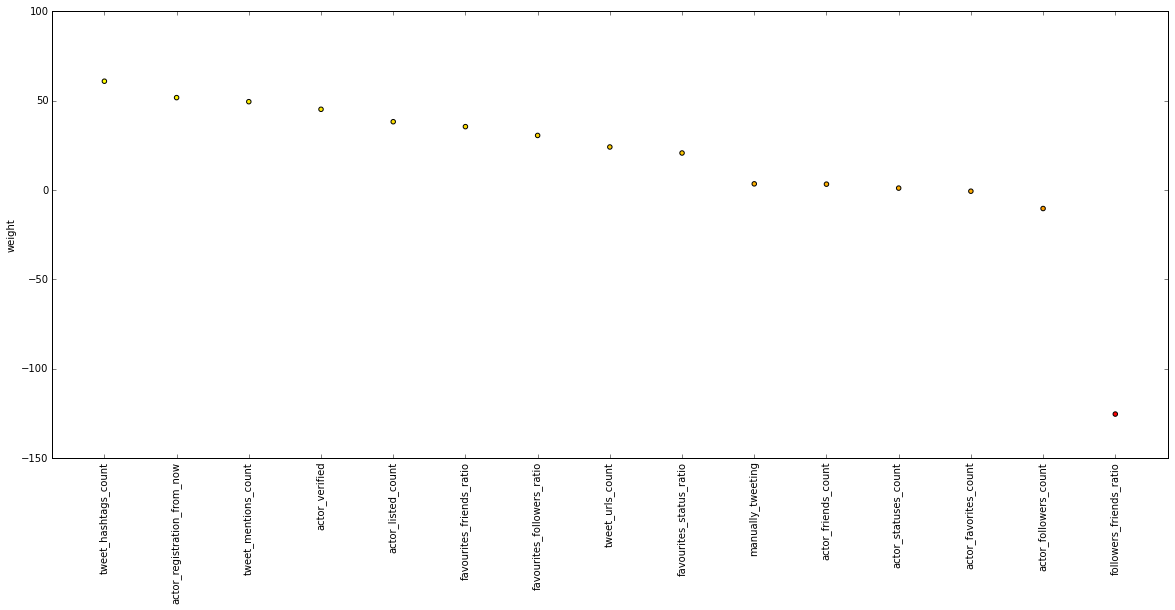

In [163]:
### Cross-validation
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

import numpy

from sklearn import linear_model, datasets
from sklearn.metrics import confusion_matrix

#cols = data.columns
cols = data.columns[0:len(tweets_features_cols)]
cols = list(set(cols) - set(['class']))
print(cols)

k_fold = KFold(n=len(data), n_folds=6, indices=False, shuffle=True)
b_scores, svc_scores = [], []

for train_indices, test_indices in k_fold:
  train = numpy.asarray(data[train_indices][cols])
  train_y    = numpy.asarray(data[train_indices]['class'])

  test = numpy.asarray(data[test_indices][cols])
  test_y     = numpy.asarray(data[test_indices]['class'])

  logreg = linear_model.LogisticRegression(C=1e5)
  logreg.fit(train, train_y)
    
  pred_y = logreg.predict(test)
  print(confusion_matrix(test_y, pred_y))
  print('score:' + str(logreg.score(test, test_y)))
    
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(data[cols], data['class'])
plot_feature_scores(clf.coef_.ravel(), cols)

Index(['actor_favorites_count', 'actor_followers_count', 'actor_friends_count', 'actor_listed_count', 'actor_registration_from_now', 'actor_statuses_count', 'actor_verified', 'favourites_followers_ratio', 'favourites_friends_ratio', 'favourites_status_ratio', 'followers_friends_ratio', 'manually_tweeting', 'tweet_hashtags_count', 'tweet_mentions_count', 'tweet_urls_count'], dtype='object')
[[206   1]
 [  6 212]]
score:0.983529411765
[[227   0]
 [  5 193]]
score:0.988235294118
[[194   0]
 [  6 225]]
score:0.985882352941
[[218   0]
 [  7 200]]
score:0.983529411765
[[210   0]
 [  3 212]]
score:0.992941176471
[[219   0]
 [  3 203]]
score:0.992941176471
done


/Users/felipeclopes/Projects/anaconda/envs/py33/lib/python3.3/site-packages/sklearn/cross_validation.py:65: DeprecationWarning: The indices parameter is deprecated and will be removed (assumed True) in 0.17
  stacklevel=1)


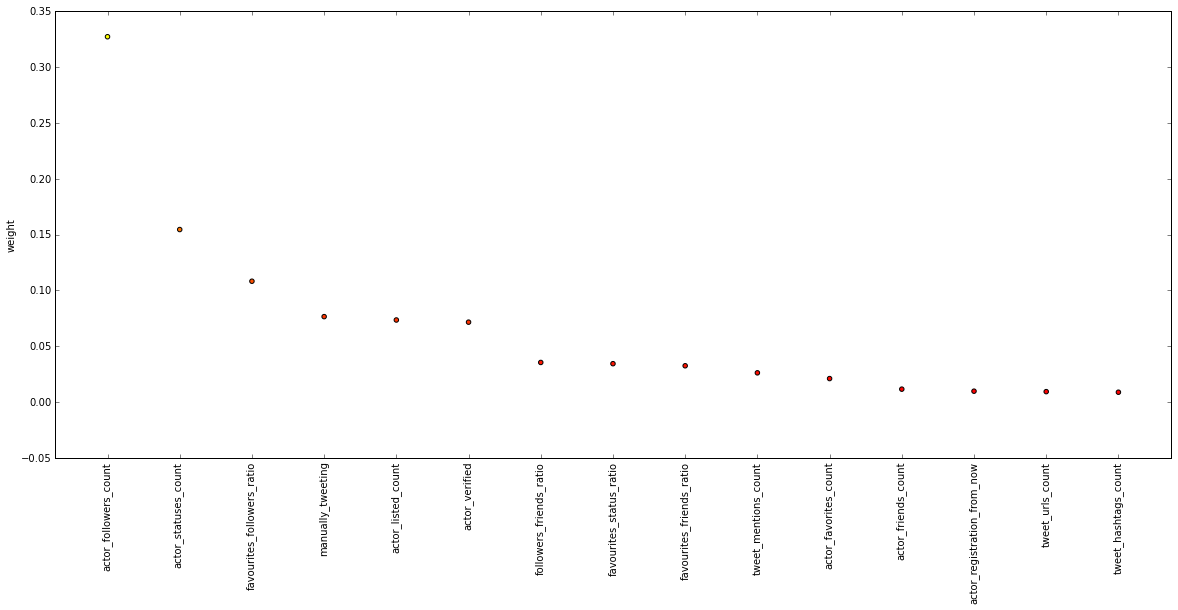

In [164]:
%matplotlib inline  

### Cross-validation
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

import numpy as np

from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

cols = result.columns[0:len(tweets_features_cols)]
cols = cols - ['class']
print(cols)

k_fold = KFold(n=len(data), n_folds=6, indices=False, shuffle=True)
b_scores, svc_scores = [], []

for train_indices, test_indices in k_fold:
  train = numpy.asarray(data[train_indices][cols])
  train_y    = numpy.asarray(data[train_indices]['class'])

  test = numpy.asarray(data[test_indices][cols])
  test_y     = numpy.asarray(data[test_indices]['class'])

  clf = RandomForestClassifier(n_estimators=25)
  clf.fit(train, train_y)
  clf_probs = clf.predict_proba(test)
  print(confusion_matrix(test_y, clf.predict(test)))
#  score = log_loss(test_y, clf_probs)
    
  print('score:' + str(clf.score(test, test_y)))
    
forest = RandomForestClassifier(n_estimators=25)
forest.fit(data[cols], data['class'])

plot_feature_scores(forest.feature_importances_, cols)